# Prototypical Networks
---

In [ ]:
!nvidia-smi

Mon May 18 09:26:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!pip install transformers

     |████████████████████████████████| 645kB 6.5MB/s eta 0:00:01
     |████████████████████████████████| 890kB 46.6MB/s 
     |████████████████████████████████| 1.1MB 36.1MB/s 
     |████████████████████████████████| 3.8MB 15.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=b760e0b9a4ac3b050e25a438668405dbf541017cb6b056a495c286bd89540869
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!mkdir checkpoints

In [ ]:
!cp -r /content/drive/My\ Drive/Projects/meta-infomax/checkpoints/protonet_default /content/checkpoints

In [ ]:
!unzip -q meta_infomax.zip

In [ ]:
!unzip -q configs.zip

## Import Libraries

In [ ]:
# import sys
# sys.path.append("../")
# %load_ext autoreload
# %autoreload 2

In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader

%matplotlib inline

In [ ]:
from configs.base_config import base_config as CONFIG
from meta_infomax.trainers.protonet_trainer import ProtonetTrainer

# Load Pretrained Model and Data

In [ ]:
config = {
    'exp_name': "protonet_default",
    'device': 'cuda',
    # 'data_dir': '../data/mtl-dataset/',
    'trainer': 'prototypical',
    'num_training_examples': 14000,
    'n_support': 5,
    'n_query': 20,
    'freeze_until_layer': 10,
}
CONFIG.update(config)

In [233]:
trainer = ProtonetTrainer(CONFIG)

INFO:root:Config Setting:
{'trainer': 'prototypical', 'lr': 5e-05, 'weight_decay': 0.01, 'warmup_steps': 100, 'collapse_domains': True, 'epochs': 3, 'batch_size': 16, 'valid_freq': 10, 'save_freq': 100, 'unfreeze_layers': (10, 11), 'clip_grad_norm': 1, 'validation_size': 0, 'random_state': 42, 'device': 'cuda', 'data_dir': 'data/mtl-dataset/', 'transformer_name': 'bert-base-uncased', 'domains': ['apparel', 'baby', 'books', 'camera_photo', 'electronics', 'health_personal_care', 'imdb', 'kitchen_housewares', 'magazines', 'music', 'software', 'sports_outdoors', 'toys_games', 'video'], 'train_domains': ['apparel', 'baby', 'books', 'camera_photo', 'health_personal_care', 'imdb', 'kitchen_housewares', 'magazines', 'sports_outdoors', 'toys_games'], 'val_domains': ['software', 'electronics'], 'test_domains': ['music', 'video'], 'log_level': 20, 'log_freq': 100, 'exp_name': 'protonet_default', 'num_training_examples': 14000, 'n_support': 5, 'n_query': 20, 'freeze_until_layer': 10}
INFO:transfor

In [234]:
for param in trainer.model.bert_encoder.embeddings.parameters():
    print(param.requires_grad)

False
False
False
False
False


In [235]:
for param in trainer.model.bert_encoder.pooler.parameters():
    print(param.requires_grad)

True
True


In [236]:
for bert_layer in trainer.model.bert_encoder.encoder.layer:
    print([param.requires_grad for param in bert_layer.parameters()])

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, Fals

In [ ]:
model = trainer.model
train_dls = trainer.train_dls
val_dls = trainer.val_dls
test_dls = trainer.test_dls

# Visualize Prototypes on All domains

## Get embeddings

In [ ]:
embeds = []
labels = []
domains = []

prototypes = []
prototype_labels = []
prototype_domains = []

In [ ]:
for domain_dl in np.concatenate([train_dls, test_dls]):
    neg_batch = next(iter(domain_dl[0]))
    pos_batch = next(iter(domain_dl[1]))

    neg_x = neg_batch['x']
    neg_masks = neg_batch['masks']
    neg_labels = neg_batch['labels'].tolist()
    neg_domains = neg_batch['domains']
    pos_x = pos_batch['x']
    pos_masks = pos_batch['masks']
    pos_labels = pos_batch['labels'].tolist()
    pos_domains = pos_batch['domains']

    with torch.no_grad():
        neg_embed = model(neg_x.to(CONFIG['device']), neg_masks.to(CONFIG['device']))
        pos_embed = model(pos_x.to(CONFIG['device']), pos_masks.to(CONFIG['device']))

    neg_prototype = neg_embed[:CONFIG['n_support']].mean(dim=0, keepdim=True).detach().cpu().numpy()
    pos_prototype = pos_embed[:CONFIG['n_support']].mean(dim=0, keepdim=True).detach().cpu().numpy()

    prototypes.append(neg_prototype)
    prototype_labels.append(neg_labels[0])
    prototype_domains.append(neg_domains[0])
    prototypes.append(pos_prototype)
    prototype_labels.append(pos_labels[0])
    prototype_domains.append(pos_domains[0])

    embeds.append(neg_embed.detach().cpu().numpy())
    labels.append(neg_labels)
    domains.append(neg_domains)
    embeds.append(pos_embed.detach().cpu().numpy())
    labels.append(pos_labels)
    domains.append(pos_domains)

In [ ]:
embeds = np.concatenate(embeds)
labels = np.concatenate(labels)
domains = np.concatenate(domains)
prototypes = np.concatenate(prototypes)

In [241]:
embeds.shape, prototypes.shape, labels.shape, domains.shape, prototype_labels, prototype_domains

((600, 256),
 (24, 256),
 (600,),
 (600,),
 [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
 ['apparel',
  'apparel',
  'baby',
  'baby',
  'books',
  'books',
  'camera_photo',
  'camera_photo',
  'health_personal_care',
  'health_personal_care',
  'imdb',
  'imdb',
  'kitchen_housewares',
  'kitchen_housewares',
  'magazines',
  'magazines',
  'sports_outdoors',
  'sports_outdoors',
  'toys_games',
  'toys_games',
  'music',
  'music',
  'video',
  'video'])

In [ ]:
prototypes_embeds = np.concatenate([prototypes, embeds])
prototypes_embeds_labels = np.concatenate([np.array(prototype_labels), labels])
prototypes_embeds_domains = np.concatenate([np.array(prototype_domains), domains])

In [243]:
prototypes_embeds.shape, prototypes_embeds_labels.shape, prototypes_embeds_domains.shape

((624, 256), (624,), (624,))

## 2D projection of embeddings

In [ ]:
embeds_2d = TSNE(n_components=2).fit_transform(embeds)

In [ ]:
prototypes_2d = TSNE(n_components=2).fit_transform(prototypes)

In [ ]:
prototypes_embeds_2d = TSNE(n_components=2).fit_transform(prototypes_embeds)

Text(0.5, 1.0, 'Prototype Embeddings')

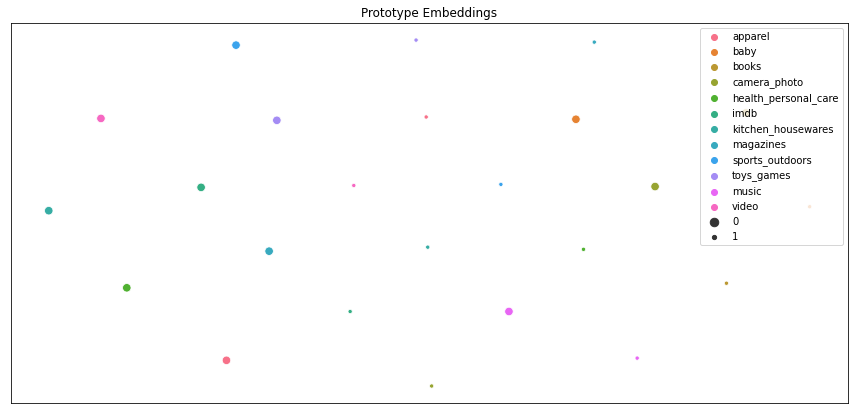

In [250]:
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.scatterplot(x=prototypes_2d[:,0], y=prototypes_2d[:,1], hue=prototype_domains, size=prototype_labels)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Prototype Embeddings')

Text(0.5, 1.0, 'Data Embeddings')

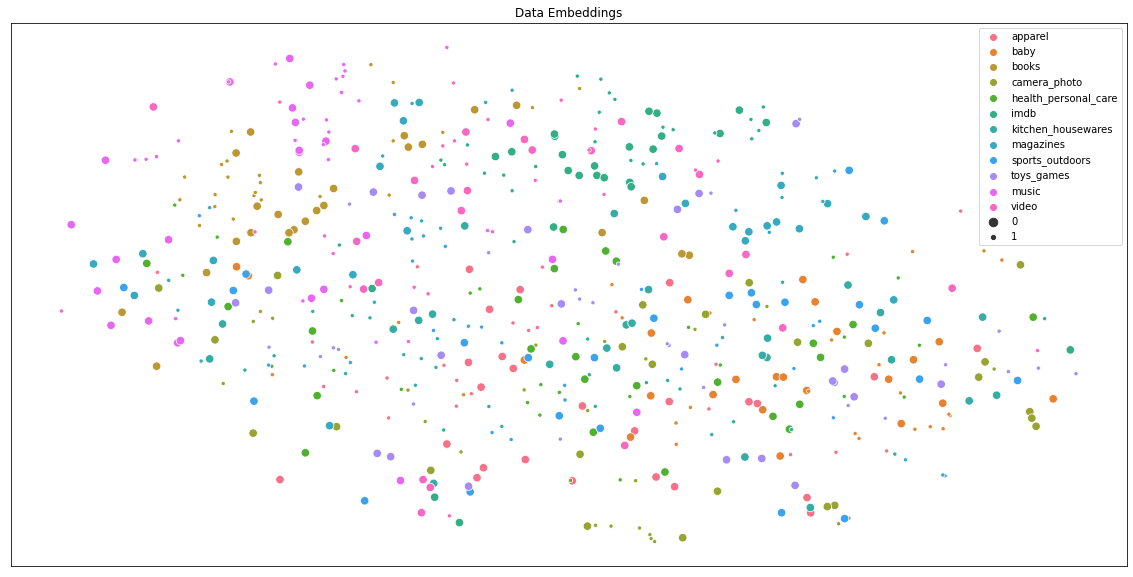

In [251]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(x=embeds_2d[:,0], y=embeds_2d[:,1], hue=domains, size=labels)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Data Embeddings')

Text(0.5, 1.0, 'Prototype and Data Embeddings')

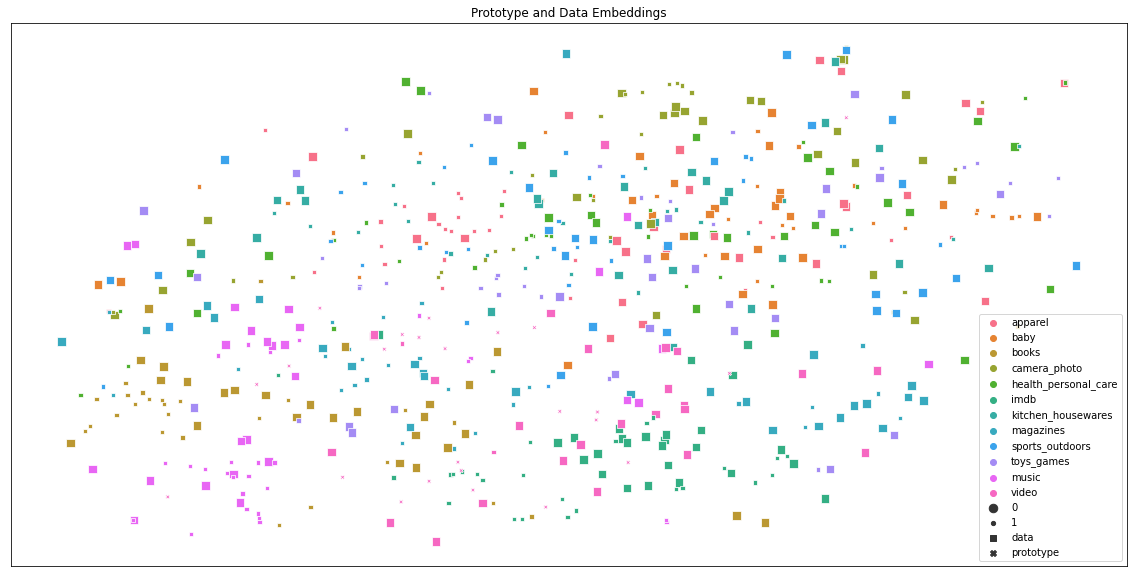

In [254]:
fig, ax = plt.subplots(figsize=(20,10))

prototype_markers = np.empty_like(prototypes_embeds_labels, dtype=object)
prototype_markers[:labels.shape[0]] = 'data'
prototype_markers[labels.shape[0]:] = 'prototype'
markers = {'data': 's', 'prototype': 'X'}

ax = sns.scatterplot(x=prototypes_embeds_2d[:,0], y=prototypes_embeds_2d[:,1],
                    hue=prototypes_embeds_domains, size=prototypes_embeds_labels,
                     style=prototype_markers, markers=markers)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Prototype and Data Embeddings')

In [255]:
prototype_markers.shape, prototypes_embeds_2d.shape

((624,), (624, 2))

# Test Domains

## Get embeddings

In [ ]:
embeds = []
labels = []
domains = []

prototypes = []
prototype_labels = []
prototype_domains = []

In [ ]:
for domain_dl in np.concatenate([test_dls]):
    neg_batch = next(iter(domain_dl[0]))
    pos_batch = next(iter(domain_dl[1]))

    neg_x = neg_batch['x']
    neg_masks = neg_batch['masks']
    neg_labels = neg_batch['labels'].tolist()
    neg_domains = neg_batch['domains']
    pos_x = pos_batch['x']
    pos_masks = pos_batch['masks']
    pos_labels = pos_batch['labels'].tolist()
    pos_domains = pos_batch['domains']

    with torch.no_grad():
        neg_embed = model(neg_x.to(CONFIG['device']), neg_masks.to(CONFIG['device']))
        pos_embed = model(pos_x.to(CONFIG['device']), pos_masks.to(CONFIG['device']))

    neg_prototype = neg_embed[:CONFIG['n_support']].mean(dim=0, keepdim=True).detach().cpu().numpy()
    pos_prototype = pos_embed[:CONFIG['n_support']].mean(dim=0, keepdim=True).detach().cpu().numpy()

    prototypes.append(neg_prototype)
    prototype_labels.append(neg_labels[0])
    prototype_domains.append(neg_domains[0])
    prototypes.append(pos_prototype)
    prototype_labels.append(pos_labels[0])
    prototype_domains.append(pos_domains[0])

    embeds.append(neg_embed.detach().cpu().numpy())
    labels.append(neg_labels)
    domains.append(neg_domains)
    embeds.append(pos_embed.detach().cpu().numpy())
    labels.append(pos_labels)
    domains.append(pos_domains)

In [ ]:
embeds = np.concatenate(embeds)
labels = np.concatenate(labels)
domains = np.concatenate(domains)
prototypes = np.concatenate(prototypes)

In [259]:
embeds.shape, prototypes.shape, labels.shape, domains.shape, prototype_labels, prototype_domains

((100, 256),
 (4, 256),
 (100,),
 (100,),
 [0, 1, 0, 1],
 ['music', 'music', 'video', 'video'])

In [ ]:
prototypes_embeds = np.concatenate([prototypes, embeds])
prototypes_embeds_labels = np.concatenate([np.array(prototype_labels), labels])
prototypes_embeds_domains = np.concatenate([np.array(prototype_domains), domains])

In [261]:
prototypes_embeds.shape, prototypes_embeds_labels.shape, prototypes_embeds_domains.shape

((104, 256), (104,), (104,))

## 2D projection of embeddings

In [ ]:
embeds_2d = TSNE(n_components=2).fit_transform(embeds)

In [ ]:
prototypes_2d = TSNE(n_components=2).fit_transform(prototypes)

In [ ]:
prototypes_embeds_2d = TSNE(n_components=2).fit_transform(prototypes_embeds)

Text(0.5, 1.0, 'Prototype Embeddings')

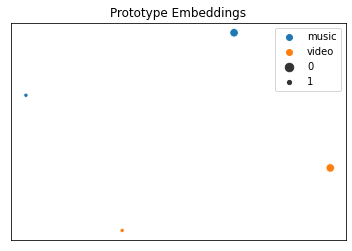

In [265]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x=prototypes_2d[:,0], y=prototypes_2d[:,1], hue=prototype_domains, size=prototype_labels)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Prototype Embeddings')

Text(0.5, 1.0, 'Data Embeddings')

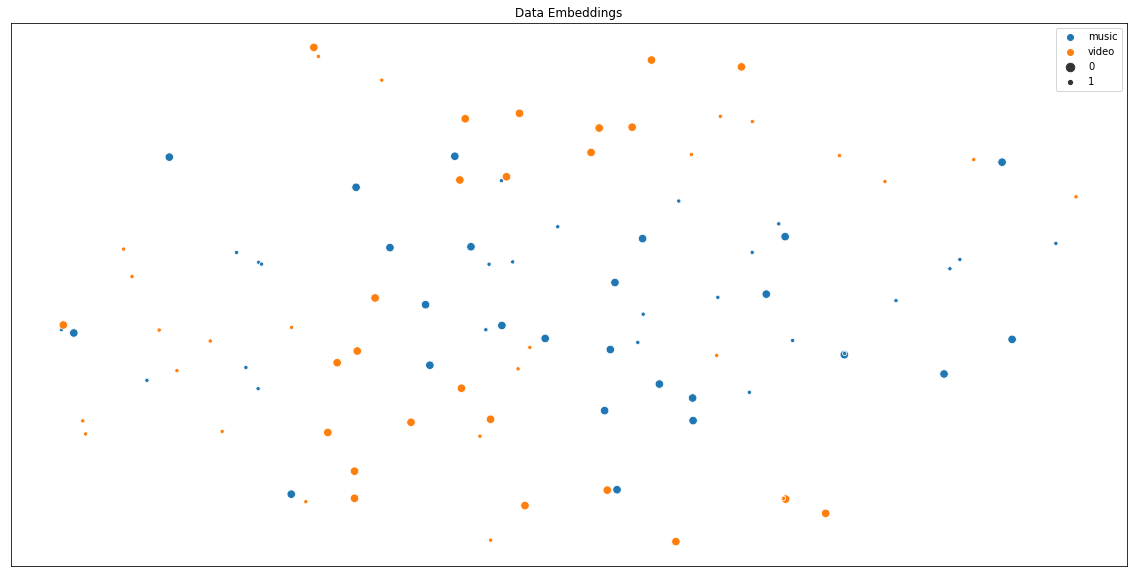

In [268]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(x=embeds_2d[:,0], y=embeds_2d[:,1], hue=domains, size=labels)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Data Embeddings')

Text(0.5, 1.0, 'Prototype and Data Embeddings')

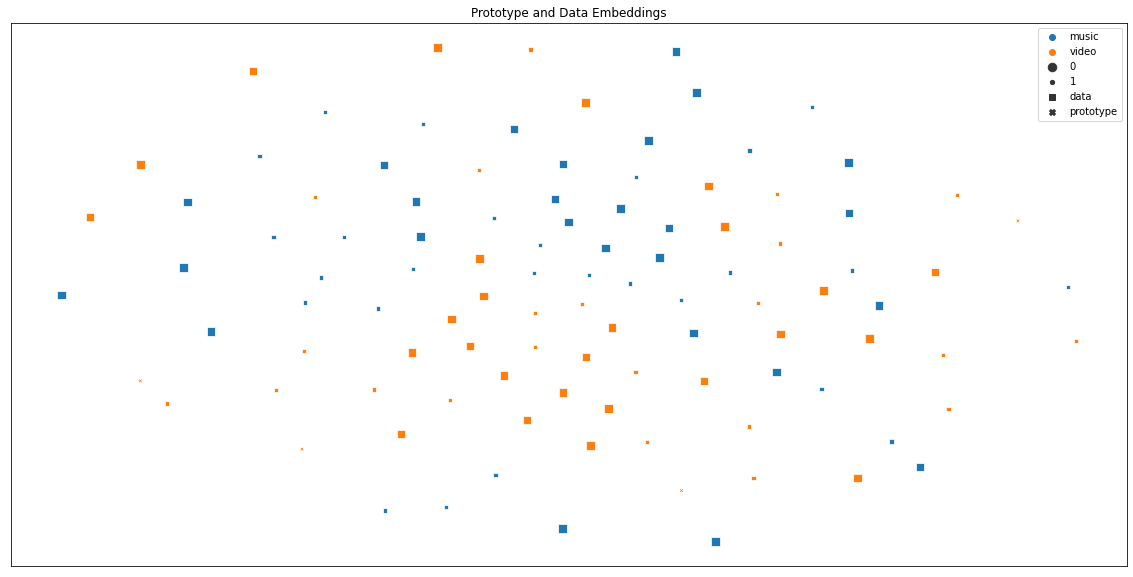

In [269]:
fig, ax = plt.subplots(figsize=(20,10))

prototype_markers = np.empty_like(prototypes_embeds_labels, dtype=object)
prototype_markers[:labels.shape[0]] = 'data'
prototype_markers[labels.shape[0]:] = 'prototype'
markers = {'data': 's', 'prototype': 'X'}

ax = sns.scatterplot(x=prototypes_embeds_2d[:,0], y=prototypes_embeds_2d[:,1],
                    hue=prototypes_embeds_domains, size=prototypes_embeds_labels,
                     style=prototype_markers, markers=markers)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Prototype and Data Embeddings')

In [ ]:
prototype_markers.shape, prototypes_embeds_2d.shape

((104,), (104, 2))

# Train Domains

## Get embeddings

In [ ]:
embeds = []
labels = []
domains = []

prototypes = []
prototype_labels = []
prototype_domains = []

In [ ]:
for domain_dl in np.concatenate([train_dls]):
    neg_batch = next(iter(domain_dl[0]))
    pos_batch = next(iter(domain_dl[1]))

    neg_x = neg_batch['x']
    neg_masks = neg_batch['masks']
    neg_labels = neg_batch['labels'].tolist()
    neg_domains = neg_batch['domains']
    pos_x = pos_batch['x']
    pos_masks = pos_batch['masks']
    pos_labels = pos_batch['labels'].tolist()
    pos_domains = pos_batch['domains']

    with torch.no_grad():
        neg_embed = model(neg_x.to(CONFIG['device']), neg_masks.to(CONFIG['device']))
        pos_embed = model(pos_x.to(CONFIG['device']), pos_masks.to(CONFIG['device']))

    neg_prototype = neg_embed[:CONFIG['n_support']].mean(dim=0, keepdim=True).detach().cpu().numpy()
    pos_prototype = pos_embed[:CONFIG['n_support']].mean(dim=0, keepdim=True).detach().cpu().numpy()

    prototypes.append(neg_prototype)
    prototype_labels.append(neg_labels[0])
    prototype_domains.append(neg_domains[0])
    prototypes.append(pos_prototype)
    prototype_labels.append(pos_labels[0])
    prototype_domains.append(pos_domains[0])

    embeds.append(neg_embed.detach().cpu().numpy())
    labels.append(neg_labels)
    domains.append(neg_domains)
    embeds.append(pos_embed.detach().cpu().numpy())
    labels.append(pos_labels)
    domains.append(pos_domains)

In [ ]:
embeds = np.concatenate(embeds)
labels = np.concatenate(labels)
domains = np.concatenate(domains)
prototypes = np.concatenate(prototypes)

In [273]:
embeds.shape, prototypes.shape, labels.shape, domains.shape, prototype_labels, prototype_domains

((500, 256),
 (20, 256),
 (500,),
 (500,),
 [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
 ['apparel',
  'apparel',
  'baby',
  'baby',
  'books',
  'books',
  'camera_photo',
  'camera_photo',
  'health_personal_care',
  'health_personal_care',
  'imdb',
  'imdb',
  'kitchen_housewares',
  'kitchen_housewares',
  'magazines',
  'magazines',
  'sports_outdoors',
  'sports_outdoors',
  'toys_games',
  'toys_games'])

In [ ]:
prototypes_embeds = np.concatenate([prototypes, embeds])
prototypes_embeds_labels = np.concatenate([np.array(prototype_labels), labels])
prototypes_embeds_domains = np.concatenate([np.array(prototype_domains), domains])

In [275]:
prototypes_embeds.shape, prototypes_embeds_labels.shape, prototypes_embeds_domains.shape

((520, 256), (520,), (520,))

## 2D projection of embeddings

In [ ]:
embeds_2d = TSNE(n_components=2).fit_transform(embeds)

In [ ]:
prototypes_2d = TSNE(n_components=2).fit_transform(prototypes)

In [ ]:
prototypes_embeds_2d = TSNE(n_components=2).fit_transform(prototypes_embeds)

Text(0.5, 1.0, 'Prototype Embeddings')

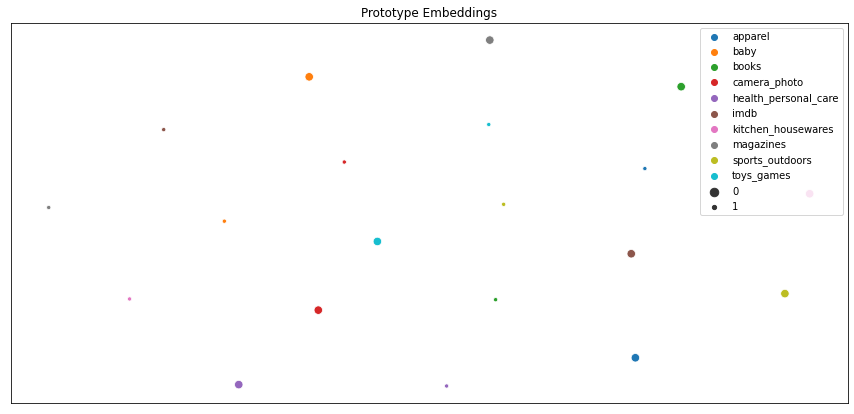

In [280]:
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.scatterplot(x=prototypes_2d[:,0], y=prototypes_2d[:,1], hue=prototype_domains, size=prototype_labels)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Prototype Embeddings')

Text(0.5, 1.0, 'Data Embeddings')

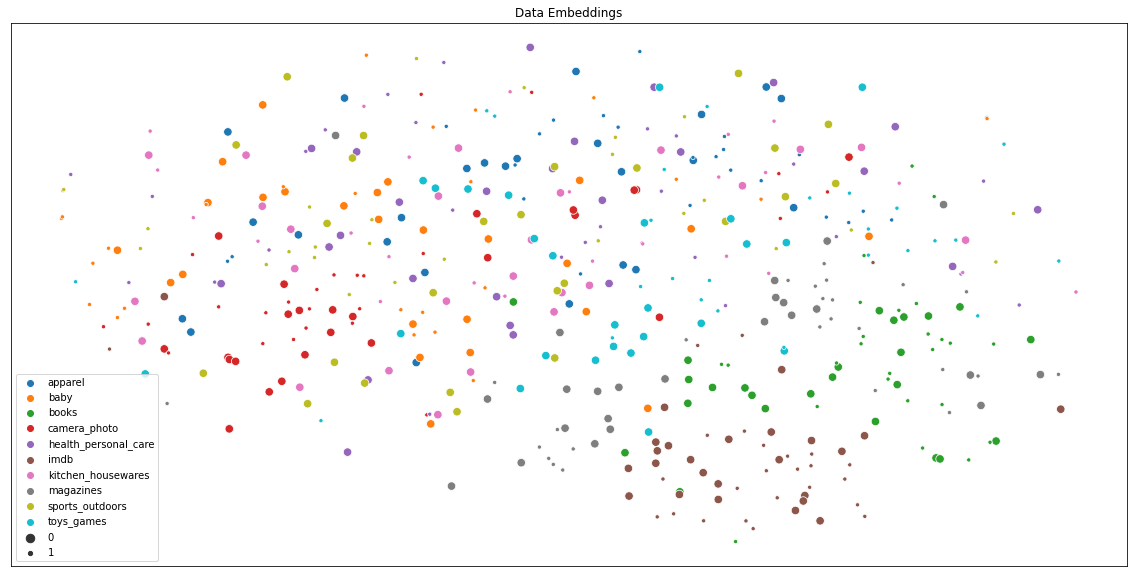

In [281]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(x=embeds_2d[:,0], y=embeds_2d[:,1], hue=domains, size=labels)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Data Embeddings')

Text(0.5, 1.0, 'Prototype and Data Embeddings')

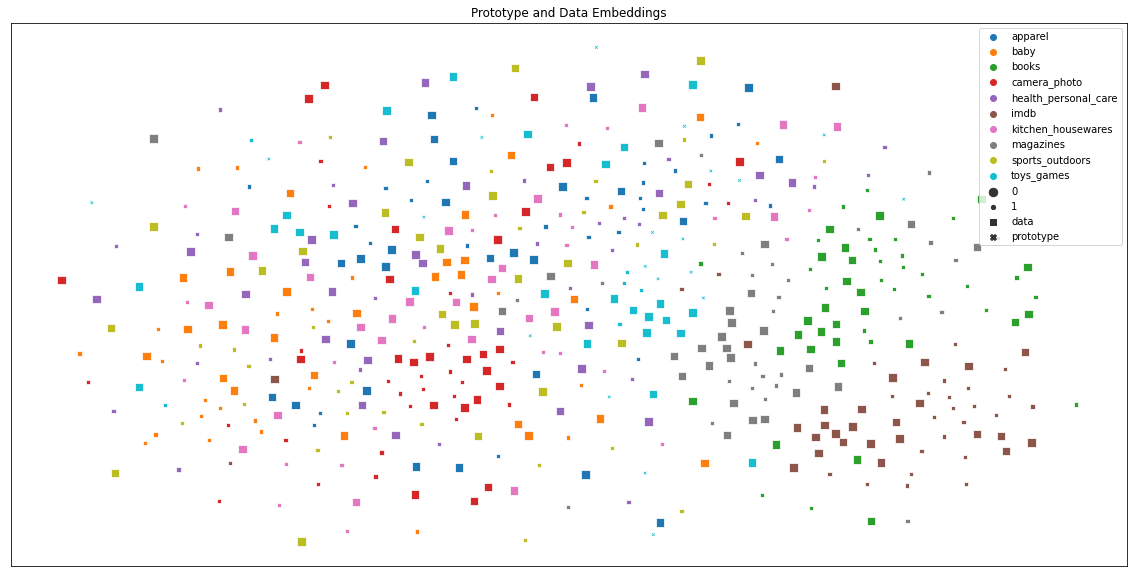

In [282]:
fig, ax = plt.subplots(figsize=(20,10))

prototype_markers = np.empty_like(prototypes_embeds_labels, dtype=object)
prototype_markers[:labels.shape[0]] = 'data'
prototype_markers[labels.shape[0]:] = 'prototype'
markers = {'data': 's', 'prototype': 'X'}

ax = sns.scatterplot(x=prototypes_embeds_2d[:,0], y=prototypes_embeds_2d[:,1],
                    hue=prototypes_embeds_domains, size=prototypes_embeds_labels,
                     style=prototype_markers, markers=markers)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Prototype and Data Embeddings')

In [283]:
prototype_markers.shape, prototypes_embeds_2d.shape

((520,), (520, 2))

# Validation Domains

## Get embeddings

In [ ]:
embeds = []
labels = []
domains = []

prototypes = []
prototype_labels = []
prototype_domains = []

In [ ]:
for domain_dl in np.concatenate([val_dls]):
    neg_batch = next(iter(domain_dl[0]))
    pos_batch = next(iter(domain_dl[1]))

    neg_x = neg_batch['x']
    neg_masks = neg_batch['masks']
    neg_labels = neg_batch['labels'].tolist()
    neg_domains = neg_batch['domains']
    pos_x = pos_batch['x']
    pos_masks = pos_batch['masks']
    pos_labels = pos_batch['labels'].tolist()
    pos_domains = pos_batch['domains']

    with torch.no_grad():
        neg_embed = model(neg_x.to(CONFIG['device']), neg_masks.to(CONFIG['device']))
        pos_embed = model(pos_x.to(CONFIG['device']), pos_masks.to(CONFIG['device']))

    neg_prototype = neg_embed[:CONFIG['n_support']].mean(dim=0, keepdim=True).detach().cpu().numpy()
    pos_prototype = pos_embed[:CONFIG['n_support']].mean(dim=0, keepdim=True).detach().cpu().numpy()

    prototypes.append(neg_prototype)
    prototype_labels.append(neg_labels[0])
    prototype_domains.append(neg_domains[0])
    prototypes.append(pos_prototype)
    prototype_labels.append(pos_labels[0])
    prototype_domains.append(pos_domains[0])

    embeds.append(neg_embed.detach().cpu().numpy())
    labels.append(neg_labels)
    domains.append(neg_domains)
    embeds.append(pos_embed.detach().cpu().numpy())
    labels.append(pos_labels)
    domains.append(pos_domains)

In [ ]:
embeds = np.concatenate(embeds)
labels = np.concatenate(labels)
domains = np.concatenate(domains)
prototypes = np.concatenate(prototypes)

In [287]:
embeds.shape, prototypes.shape, labels.shape, domains.shape, prototype_labels, prototype_domains

((100, 256),
 (4, 256),
 (100,),
 (100,),
 [0, 1, 0, 1],
 ['software', 'software', 'electronics', 'electronics'])

In [ ]:
prototypes_embeds = np.concatenate([prototypes, embeds])
prototypes_embeds_labels = np.concatenate([np.array(prototype_labels), labels])
prototypes_embeds_domains = np.concatenate([np.array(prototype_domains), domains])

In [289]:
prototypes_embeds.shape, prototypes_embeds_labels.shape, prototypes_embeds_domains.shape

((104, 256), (104,), (104,))

## 2D projection of embeddings

In [ ]:
embeds_2d = TSNE(n_components=2).fit_transform(embeds)

In [ ]:
prototypes_2d = TSNE(n_components=2).fit_transform(prototypes)

In [ ]:
prototypes_embeds_2d = TSNE(n_components=2).fit_transform(prototypes_embeds)

Text(0.5, 1.0, 'Prototype Embeddings')

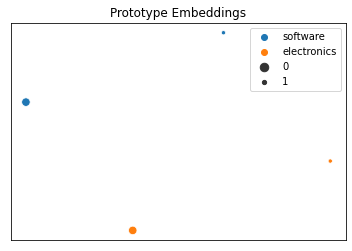

In [293]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x=prototypes_2d[:,0], y=prototypes_2d[:,1], hue=prototype_domains, size=prototype_labels)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Prototype Embeddings')

Text(0.5, 1.0, 'Data Embeddings')

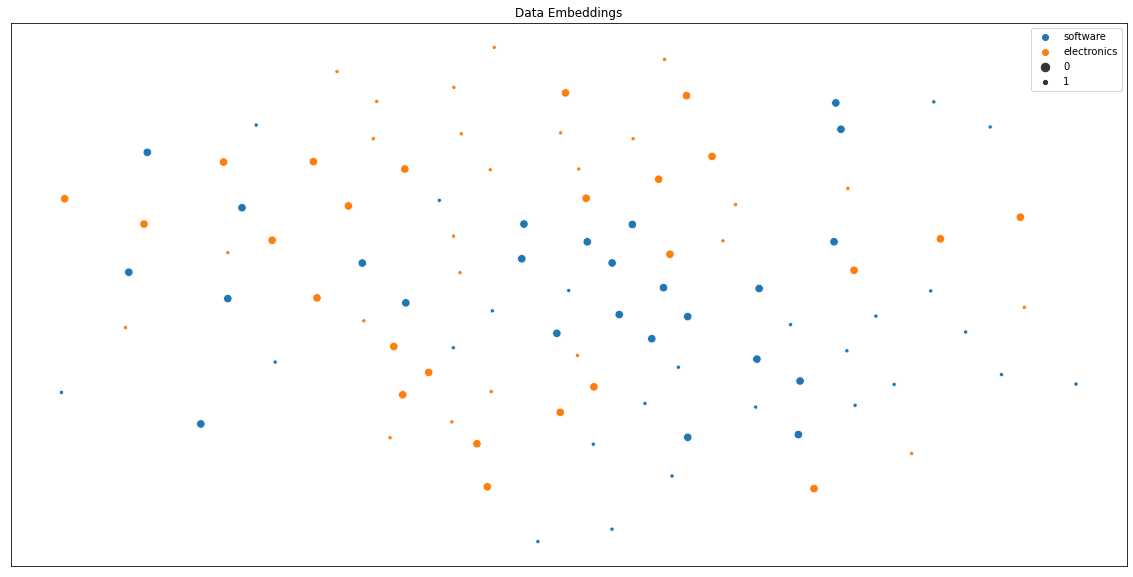

In [294]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(x=embeds_2d[:,0], y=embeds_2d[:,1], hue=domains, size=labels)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Data Embeddings')

Text(0.5, 1.0, 'Prototype and Data Embeddings')

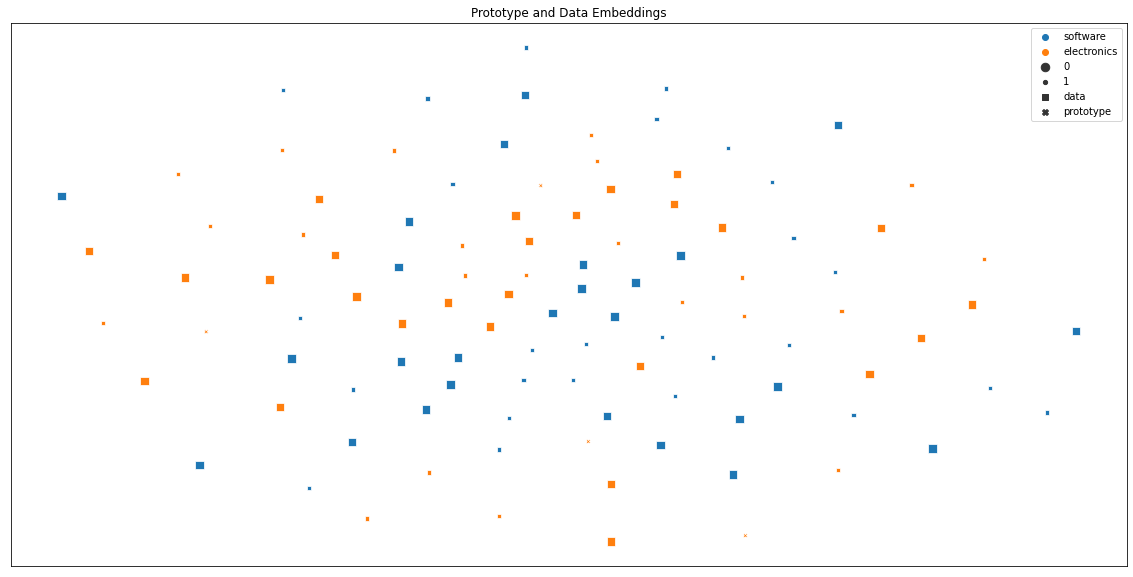

In [295]:
fig, ax = plt.subplots(figsize=(20,10))

prototype_markers = np.empty_like(prototypes_embeds_labels, dtype=object)
prototype_markers[:labels.shape[0]] = 'data'
prototype_markers[labels.shape[0]:] = 'prototype'
markers = {'data': 's', 'prototype': 'X'}

ax = sns.scatterplot(x=prototypes_embeds_2d[:,0], y=prototypes_embeds_2d[:,1],
                    hue=prototypes_embeds_domains, size=prototypes_embeds_labels,
                     style=prototype_markers, markers=markers)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Prototype and Data Embeddings')

In [230]:
prototype_markers.shape, prototypes_embeds_2d.shape

((104,), (104, 2))